In [245]:
import acquire
import pandas as pd
import numpy as np
import nltk
import prepare
from tqdm.notebook import tqdm_notebook
import time
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline,Pipeline

import warnings
warnings.filterwarnings("ignore")

In [246]:
df = acquire.github_df()

In [247]:
df = df.dropna()

In [248]:
df = prepare.prepare_df(df,'readme_contents', extra_words = ['also', '&#9', 'e', 'f', 'ou', 'et', 'n', '1', "'", ';', '3', 'e', 'p'])

In [249]:
df.language.value_counts()

other         338
JavaScript    271
Python        187
TypeScript     71
Shell          36
C#             28
Name: language, dtype: int64

In [250]:
df = df.drop(columns=['stem_length','stemmed_word_count'])

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 931 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   repo                   931 non-null    object
 1   language               931 non-null    object
 2   readme_contents        931 non-null    object
 3   clean                  931 non-null    object
 4   stemmed                931 non-null    object
 5   lemmatized             931 non-null    object
 6   original_length        931 non-null    int64 
 7   lem_length             931 non-null    int64 
 8   original_word_count    931 non-null    int64 
 9   lemmatized_word_count  931 non-null    int64 
dtypes: int64(4), object(6)
memory usage: 80.0+ KB


In [252]:
train, validate, test = prepare.train_validate_test_split(df)

In [253]:
train.head()

,repo,language,readme_contents,clean,stemmed,lemmatized,original_length,lem_length,original_word_count,lemmatized_word_count
160,ga-wdi-exercises/spotify-me,other,# Spotify.me\n\nUse Ajax to load data from the...,spotifyme use ajax load data spotify api user ...,spotifym use ajax load data spotifi api user a...,spotifyme use ajax load data spotify api user ...,442,288,74,41
231,spotify/spotify-web-playback-sdk-example,JavaScript,# Web Playback SDK Javascript Tutorial\n\nThis...,web playback sdk javascript tutorial repositor...,web playback sdk javascript tutori repositori ...,web playback sdk javascript tutorial repositor...,1761,1236,202,117
889,dtcrout/spotitude,Python,# Spotitude\n\nYet another Spotify user analyt...,spotitude yet another spotify user analytics v...,spotitud yet anoth spotifi user analyt visual ...,spotitude yet another spotify user analytics v...,2282,1495,345,185
677,pckhib/node-red-contrib-spotify,other,# Node-RED node for Spotify Web API\n\nThis no...,nodered node spotify web api node nodered wrap...,noder node spotifi web api node noder wrapper ...,nodered node spotify web api node nodered wrap...,1915,1384,244,148
563,neonichu/CoolSpot,other,# CoolSpot\n\n![Screenshot of playback on the ...,coolspot screenshot playback watchscreenshotsw...,coolspot screenshot playback watchscreenshotsw...,coolspot screenshot playback watchscreenshotsw...,1392,865,191,100


In [254]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    languages = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    languages.columns = ['n', 'percent']
    languages
    return languages

languages = show_counts_and_ratios(df, "language")


In [255]:
languages.tail(11)

,n,percent
other,338,0.363050
JavaScript,271,0.291085
Python,187,0.200859
TypeScript,71,0.076262
Shell,36,0.038668
C#,28,0.030075


In [256]:
java_words = (' '.join(train[train.language == 'JavaScript'].lemmatized))
python_words = (' '.join(train[train.language == 'Python'].lemmatized))
typescript_words =(' '.join(train[train.language == 'TypeScript'].lemmatized))
shell_words = (' '.join(train[train.language == 'Shell'].lemmatized))
csharp_words = (' '.join(train[train.language == 'C#'].lemmatized))
all_words = (' '.join(train.lemmatized))


In [257]:
java_freq = pd.Series(java_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
typescript_freq = pd.Series(typescript_words.split()).value_counts()
shell_freq = pd.Series(shell_words.split()).value_counts()
csharp_freq = pd.Series(csharp_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [258]:
csharp_freq.head()

spotify          96
version          38
authorization    30
fixed            30
net              27
dtype: int64

In [259]:
word_counts = (pd.concat([all_freq, java_freq, python_freq, typescript_freq, shell_freq, csharp_freq], axis=1, sort=True)
                .set_axis(['all', 'java', 'python','typescript','shell','csharp'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()


,all,java,python,typescript,shell,csharp
0,340,23,26,19,4,3
00,18,8,0,0,0,0
000,4,1,0,0,0,0
0000,2,0,0,0,0,0
000000,1,0,0,0,0,0


In [260]:
word_counts.sort_values(by='all', ascending=False).head(10)


,all,java,python,typescript,shell,csharp
spotify,2789,749,559,280,137,96
track,1151,287,158,159,27,27
playlist,1123,252,275,159,19,14
use,931,313,177,56,33,18
install,881,236,291,33,45,4
file,830,308,209,39,20,9
user,825,167,123,140,13,24
run,815,321,180,62,19,8
song,796,145,250,53,16,9
get,765,166,120,158,13,13


In [261]:
pd.concat([word_counts[word_counts.java == 0].sort_values(by='java').tail(6),
           word_counts[word_counts.python == 0].sort_values(by='python').tail(6),
           word_counts[word_counts.typescript == 0].sort_values(by='typescript').tail(6),
           word_counts[word_counts.shell == 0].sort_values(by='shell').tail(6),
           word_counts[word_counts.csharp == 0].sort_values(by='csharp').tail(6)])


,all,java,python,typescript,shell,csharp
handlerahkactionsheet,1,0,0,0,0,0
handlersrcfluentspotifyapiauthorizationflowsaspnetcoreauthorizationcodehandlerspotifyhandlercs,1,0,0,0,0,1
handletransienthttperror,1,0,0,0,0,1
handleurleventevent,1,0,0,0,0,0
half,9,0,1,0,0,2
zypperhttpwikilinks2linuxdepackmanfaqensoftwareinstallationupdatesdeinstallation,1,0,0,0,1,0
gmusicusernameusername,1,0,0,0,0,0
gmusicpasswordpassword,1,0,0,0,0,0
gmusicapi,2,0,0,0,0,0
gmessagesdebugplayerctl,1,0,0,0,0,0


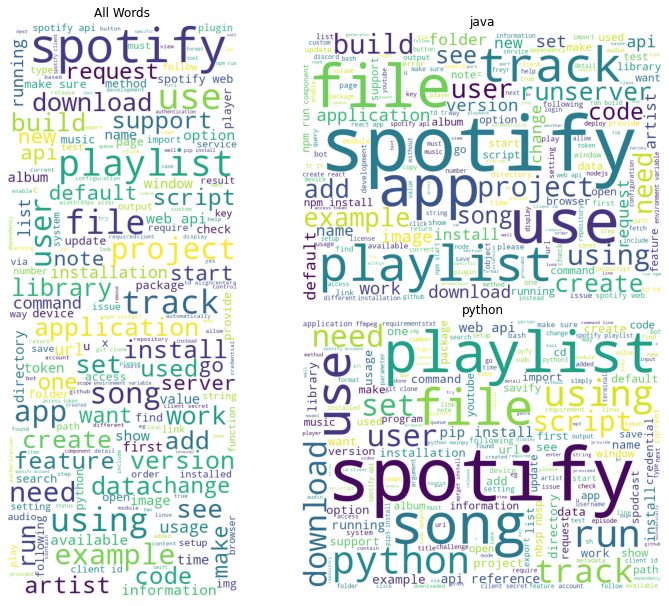

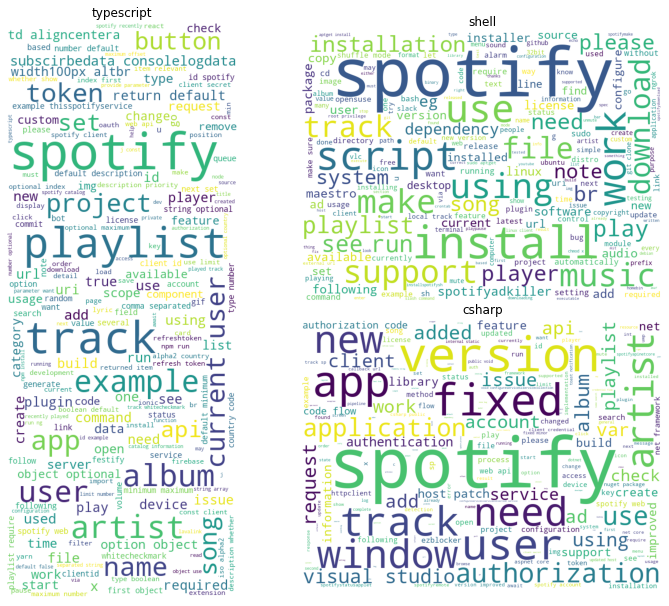

In [262]:

all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(all_words)
java_cloud = WordCloud(background_color='white', height=600, width=800).generate(java_words)
python_cloud = WordCloud(background_color='white', height=600, width=800).generate(python_words)
typescript_cloud = WordCloud(background_color='white', height=1000, width=400).generate(typescript_words)
shell_cloud = WordCloud(background_color='white', height=600, width=800).generate(shell_words)
csharp_cloud = WordCloud(background_color='white', height=600, width=800).generate(csharp_words)

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(java_cloud)
axs[2].imshow(python_cloud)

axs[0].set_title('All Words')
axs[1].set_title('java')
axs[2].set_title('python')

for ax in axs: ax.axis('off')
    
plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(typescript_cloud)
axs[1].imshow(shell_cloud)
axs[2].imshow(csharp_cloud)

axs[0].set_title('typescript')
axs[1].set_title('shell')
axs[2].set_title('csharp')

for ax in axs: ax.axis('off')


In [263]:
bigrams = nltk.ngrams(all_words.split(), 2)

In [264]:
python_bigrams=(pd.Series(nltk.ngrams(python_words.split(), 2))
                      .value_counts()
                      .head(20))

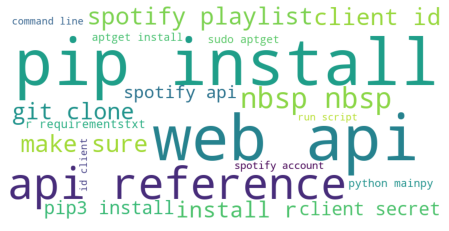

In [265]:
data = {k[0] + ' ' + k[1]: v for k, v in python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [266]:
tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(train.lemmatized)
tfidfs

<520x23546 sparse matrix of type '<class 'numpy.float64'>'
	with 76751 stored elements in Compressed Sparse Row format>

In [267]:
pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())


,00,000,0000,000000,00005,00008000,00059633501235151045timesignature,0006420602303837413mode,002,0023221514930213242key,...,zoom,zs10awcwm4uwpjr3mxxdwe03fda0j0zn95s4hu3qxlvhfajjw8es98ftmpaava7zh735x9s22pan0l,zscroll,zscrollhttpsgithubcomnoctuidzscroll,zscrollhttpsgithubcomnoctuidzscrollinstallation,zsh,zxvf,zypper,zypperhttpwikilinks2linuxdepackmanfaqensoftwareinstallationupdatesdeinstallation,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [268]:
df.language.value_counts()>1

other         True
JavaScript    True
Python        True
TypeScript    True
Shell         True
C#            True
Name: language, dtype: bool

In [269]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(df.lemmatized)
y = df.language

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(x_train, y_train)

train['lm_predicted'] = lm.predict(x_train)
test['lm_predicted'] = lm.predict(x_test)

rf = RandomForestClassifier(min_samples_leaf=2).fit(x_train, y_train)

train['rf_predicted'] = rf.predict(x_train)
test['rf_predicted'] = rf.predict(x_test)

sgd = make_pipeline(Normalizer(),
                    SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None))


sgd.fit(x_train, y_train)
train['sgd_predicted'] = sgd.predict(x_train)
test['sgd_predicted'] = sgd.predict(x_test)

In [270]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.lm_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.lm_predicted))


Accuracy: 84.14%
---
Confusion Matrix
actual        C#  JavaScript  Python  Shell  TypeScript  other
lm_predicted                                                  
JavaScript     1         212       0      0          28      4
Python         0           0     140      2           0      0
TypeScript     0           0       0      0           8      0
other         21           5       9     27          21    266
---
              precision    recall  f1-score   support

          C#       0.00      0.00      0.00        22
  JavaScript       0.87      0.98      0.92       217
      Python       0.99      0.94      0.96       149
       Shell       0.00      0.00      0.00        29
  TypeScript       1.00      0.14      0.25        57
       other       0.76      0.99      0.86       270

    accuracy                           0.84       744
   macro avg       0.60      0.51      0.50       744
weighted avg       0.80      0.84      0.79       744



In [271]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.lm_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.lm_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.lm_predicted))

Accuracy: 60.43%
---
Confusion Matrix
actual        C#  JavaScript  Python  Shell  TypeScript  other
lm_predicted                                                  
JavaScript     0          27       4      0           7      6
Python         0           0      25      0           0      1
other          6          27       9      7           7     61
---
              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         6
  JavaScript       0.61      0.50      0.55        54
      Python       0.96      0.66      0.78        38
       Shell       0.00      0.00      0.00         7
  TypeScript       0.00      0.00      0.00        14
       other       0.52      0.90      0.66        68

    accuracy                           0.60       187
   macro avg       0.35      0.34      0.33       187
weighted avg       0.56      0.60      0.56       187



In [272]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.rf_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.rf_predicted))


Accuracy: 89.38%
---
Confusion Matrix
actual        C#  JavaScript  Python  Shell  TypeScript  other
rf_predicted                                                  
C#            11           0       0      0           0      0
JavaScript     3         204       1      0          10      3
Python         0           0     135      3           0      1
Shell          0           0       0     12           0      0
TypeScript     0           0       0      0          37      0
other          8          13      13     14          10    266
---
              precision    recall  f1-score   support

          C#       1.00      0.50      0.67        22
  JavaScript       0.92      0.94      0.93       217
      Python       0.97      0.91      0.94       149
       Shell       1.00      0.41      0.59        29
  TypeScript       1.00      0.65      0.79        57
       other       0.82      0.99      0.90       270

    accuracy                           0.89       744
   macro avg       0

In [273]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.rf_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.rf_predicted))

Accuracy: 60.43%
---
Confusion Matrix
actual        C#  JavaScript  Python  Shell  TypeScript  other
rf_predicted                                                  
JavaScript     0          25       2      0           6      6
Python         0           0      26      1           0      1
TypeScript     0           0       0      0           1      0
other          6          29      10      6           7     61
---
              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         6
  JavaScript       0.64      0.46      0.54        54
      Python       0.93      0.68      0.79        38
       Shell       0.00      0.00      0.00         7
  TypeScript       1.00      0.07      0.13        14
       other       0.51      0.90      0.65        68

    accuracy                           0.60       187
   macro avg       0.51      0.35      0.35       187
weighted avg       0.64      0.60      0.56       187



In [274]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.sgd_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.sgd_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.sgd_predicted))


Accuracy: 100.00%
---
Confusion Matrix
actual         C#  JavaScript  Python  Shell  TypeScript  other
sgd_predicted                                                  
C#             22           0       0      0           0      0
JavaScript      0         217       0      0           0      0
Python          0           0     149      0           0      0
Shell           0           0       0     29           0      0
TypeScript      0           0       0      0          57      0
other           0           0       0      0           0    270
---
              precision    recall  f1-score   support

          C#       1.00      1.00      1.00        22
  JavaScript       1.00      1.00      1.00       217
      Python       1.00      1.00      1.00       149
       Shell       1.00      1.00      1.00        29
  TypeScript       1.00      1.00      1.00        57
       other       1.00      1.00      1.00       270

    accuracy                           1.00       744
   macro av

In [275]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.sgd_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.sgd_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.sgd_predicted))


Accuracy: 58.82%
---
Confusion Matrix
actual         C#  JavaScript  Python  Shell  TypeScript  other
sgd_predicted                                                  
C#              2           1       0      0           1      0
JavaScript      0          27       3      1           6      9
Python          1           6      28      0           1      7
Shell           0           1       2      4           0      2
TypeScript      0           3       0      0           4      5
other           3          16       5      2           2     45
---
              precision    recall  f1-score   support

          C#       0.50      0.33      0.40         6
  JavaScript       0.59      0.50      0.54        54
      Python       0.65      0.74      0.69        38
       Shell       0.44      0.57      0.50         7
  TypeScript       0.33      0.29      0.31        14
       other       0.62      0.66      0.64        68

    accuracy                           0.59       187
   macro avg